Contributions:

| Christian | Lucas | Mads | Task                     |
|-----------|--------|------|--------------------------|
| 30        | 40     | 30   | Import and Prep Scripts  |
| 40        | 30     | 30   | Webscraping Wookieepedia |
| 40        | 30     | 30   | SWAPI (Star Wars API)    |
| 30        | 40     | 30   | Graph Creation           |
| 40        | 30     | 30   | Basic Metrics            |
| 30        | 30     | 40   | Community Detection      |
| 30        | 40     | 30   | Wordclouds               |
| 30        | 30     | 40   | Website                  |


### Dataset Choice and Motivation

Our dataset combines three sources: scripts from *Star Wars* Episodes I-VI, character articles from Wookieepedia, and metadata from the Star Wars API (SWAPI). Wookieepedia provided rich attribute data, the scripts gave us direct dialogue interactions, and SWAPI helped refine and align characters across sources. We stumbled upon the dataset by chance—discovering Wookieepedia unexpectedly—and, as casual fans, saw clear potential. Our goal became to show how *Star Wars* characters connect across scenes, dialogue, and attributes, building an interactive experience of character relationships.

---

### Preprocessing and Dataset Stats

We began by integrating messy data from three very different formats. Wookieepedia’s free-text articles were cleaned and structured using regex and SWAPI validation. We matched characters from the scripts with Wookieepedia profiles, ending with 252 characters and their associated features. Much of the preprocessing centered on aligning entities and filtering inconsistencies across the sources.

---

### Methods and Analysis

We cleaned text using `nltk` (tokenization, stemming, stopword removal), with regex for alphabetic filtering. Statistically relevant bigrams were found via chi-squared testing and collapsed using `MWETokenizer`. For each detected community (via Louvain clustering), we computed TF-IDF scores to surface distinctive vocabulary and visualized it with `WordCloud`.

With the language patterns mapped, we complemented the analysis by examining structural relationships in the character interaction network.

On the network side, we analyzed character co-occurrence using NetworkX and detected 7 communities using the Louvain method. We measured node degree (who connects most), betweenness centrality (who bridges groups), and mapped these against shared attributes and word use. This allowed us to label some communities semantically-though some were more interpretable than others.

---

### Evaluation and Limitations

The community detection yielded meaningful groupings, and the graph structure was highly insightful for visual exploration. Generating word clouds for each group added a narrative layer to our findings and helped distinguish group identity.

That said, the dataset size limited complexity. Many character profiles lacked depth, and scraping returned noise we couldn't filter early on. Still, the process gave us a rich foundation for analysis and taught us a lot—while being fun to build!

---

### About the Notebook Structure

We chose not to format the notebook strictly into these four sections, as it would have made the experience harder to follow. Instead, we invite you to explore the notebook part-by-part through its descriptive titles. Enjoy!

In [ ]:
load_data = True
# chooses whether to import from datasets or run code (scrapers, etc.) again, for smooth experience keep the load data True
# else timeconsuming cells will run again

# Star Wars Networking Through Scripts and SWAPI

## Import and prep Scripts

Scripts dataset found on [GitHub](https://github.com/jcwieme/data-scripts-star-wars)

### Functions

In [2]:
import networkx as nx
import pandas as pd
from collections import defaultdict
import netwulf as nw
from netwulf import visualize as _visualize
from itertools import combinations
import matplotlib.pyplot as plt


movie_data_path = '../data/movies/'

community_mapping = pd.read_csv(f'{movie_data_path}movie_characters_mapping.csv', sep=';')
name_map = dict(
    zip(
        community_mapping['raw_name'].str.strip().str.lower(),
        community_mapping['translation_name'].str.strip().str.lower()
    )
)

def translate(raw_char):
    return name_map.get(raw_char.strip().lower(), raw_char.strip().lower())

### Execution

In [3]:
load_data = False

if load_data:
    df_script = pd.read_csv('../data/movies/moviescripts_compiled.csv')
else:    
    df_script = pd.DataFrame(columns=['from', 'where', 'text', 'movie_num'])

    for movie_num in range(1, 7):
        current_movie_path = f'star_wars_{movie_num}_data.csv'
        current_movie = pd.read_csv(movie_data_path + current_movie_path, sep=';')

        current_movie.replace({'from': {'nan': pd.NA}, 'to': {'nan': pd.NA}}, inplace=True)
        current_movie = current_movie[['from', 'where', 'text']]
        current_movie['movie_num'] = movie_num

        df_script = pd.concat([df_script, current_movie], ignore_index=True)

    df_script['from'] = df_script['from'].str.lower()
    df_script['text_processed'] = df_script['text'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)
    
    df_script['from'] = df_script['from'].apply(translate)

    # adds trilogy logic for df
    movies_per_char = df_script.groupby('from')['movie_num'].agg(set)
    trilogy_map = {
        name: 1 if nums <= {1,2,3}
        else 2 if nums <= {4,5,6}
        else 'both'
        for name, nums in movies_per_char.items()
    }
    df_script['trilogy'] = df_script['from'].map(trilogy_map)


    df_script.to_csv(f'{movie_data_path}moviescripts_compiled.csv', index=False)

load_data = True

df_script.sample(1)

,from,where,text,movie_num,text_processed,trilogy
4590,lando,EXT. CLOUD CITY - LANDING PLATFORM,"(laughs) How you doing, you old pirate? So goo...",5,laughs how you doing you old pirate so good to...,2


## Webscraping Wookieepedia

### Functions

In [4]:
from tqdm import tqdm
from bs4 import BeautifulSoup 
import requests
from joblib import Parallel, delayed
import pickle
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process

def scraper(category_link,original_link):
    pages = {}
    page_num = 1
    while category_link is not None:
        req = requests.get(category_link)
        soup = BeautifulSoup(req.content, "html.parser")
        
        urls = soup.find_all('a', class_='category-page__member-link') # only get ones with class as category-page__member-link 
        links_before = len(pages)
        for link in urls:
            url = original_link + link.get('href')
            # We need to only get charachters and not categories, currently we are getting all links. We use the key to filter out categories:
            key = url.split('/')[-1]
            if 'Category:' not in key:
                pages[key] = url
            
        page_num += 1

        # get next page button using the class
        next_urls = soup.find_all("a", class_='category-page__pagination-next') # In the code on the website we see the letter class for the next page button is category-page__pagination-next
        if next_urls:
            new_url = next_urls[0].get('href')
            if new_url == category_link:
                break 
            else:
                category_link = new_url
        else:
            break
    return pages

def process_page(url):
    req = requests.get(url)
    soup = BeautifulSoup(req.content, "html.parser")

    # get the name of the character
    name = soup.find('h1',class_='page-header__title').text.strip()

    # Get sidebar with info
    sidebar = soup.find('aside')
    # collect all relevant info in the sidebar
    info = {}

    for item in sidebar.find_all('div', class_='pi-item pi-data pi-item-spacing pi-border-color'):
        #get the data:
        info[item["data-source"]] = item.find('div', class_='pi-data-value pi-font').text.strip()

    # remove the references in format [X] from the data
    for key, value in info.items():
        if value is not None:
            info[key] = value.split('[')[0].strip()
        else:
            info[key] = None
    return name,info

def chunker(seq, batch_size=100):
    for pos in range(0, len(seq), batch_size):
        yield list(seq)[pos:pos + batch_size]

def find_best_match(name, choices, threshold=80):
        match, score, _ = process.extractOne(name, choices, scorer=fuzz.token_set_ratio)
        if score >= threshold:
            return match
        return None

### Execution

Finding all relevant links in the cannon category and scarping them:

In [5]:
category_link = 'https://starwars.fandom.com/wiki/Category:Canon_articles'  # all canon articles
original_link = 'https://starwars.fandom.com'

if load_data:
    with open("../data/pages_dict.pkl", "rb") as f:
        pages = pickle.load(f)
else:
    pages = scraper(category_link,original_link)
    with open("../data/pages_dict.pkl", "wb") as f:
        pickle.dump(pages, f)
        
print(f'Number of pages: {len(pages)}')

Number of pages: 49445


Processing all pages previously scraped and collection each character with attributes in dictionary

In [6]:
if load_data:
    with open("../data/characters_info_only_filled_att.pkl", "rb") as f:
        characters = pickle.load(f)
else:
    characters = {}
    all_keys = list(pages.keys())
    batch_size = 512
    results = []

    total_batches = len(all_keys) // batch_size + 1
    for batch in tqdm(chunker(all_keys, batch_size),
                                total=total_batches, 
                                desc="Processing Batches", 
                                ncols=100):
    
        batch_results = Parallel(n_jobs=-1)(
            delayed(process_page)(pages[key]) for key in batch
        )
        results.extend(batch_results)

    for name, info in results:
        if name and info:
            characters[name] = info

    with open("../data/characters_info_only_filled_att.pkl", "wb") as f:
        pickle.dump(characters, f)

print('Characters in processed data: ', len(characters))

Characters in processed data:  42826


Creating a dataframe from scraped data and cleaning names:

In [7]:
# into dataframe and process text + become column (instead of index)
df = pd.DataFrame.from_dict(characters, orient='index')

df.index.name = 'name'
df.reset_index(inplace=True)

df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.strip()
df['name'] = df['name'].str.replace('"', '', regex=False)

df.sample(1)

,name,manufacturer,type,cost,purpose,species,affiliation,gender,pronouns,hair,...,albums,form,teams,depth,candidates,electorate,stars,arms,satellites,incubationperiod
6931,malachor company,NaN,Mercenary group,NaN,NaN,NaN,Galactic Empire,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Matching characters to script names.

We keep only coloumns/attributes with more then 10% of possible entries in the final dataframe of this cell. Done to remove irrelevant coloumns.

In [8]:
# filter for first 6 movies
script_names = df_script['from'].str.lower().unique()

# Filter out rows where 'species', "affiliation",... is NaN
filtered_df = df[(df['species'].notna()) | (df["gender"].notna()) | df["class"].notna() | df["eyes"].notna() ]

# filtered_df = df[df['species'].notna()]
all_names = filtered_df['name'].unique().tolist()

# Find best matches for all movie script characters
matched_names = {}
for name in script_names:
    match = find_best_match(name, all_names)
    if match:
        matched_names[name] = match

# Filter the df_all by matched names
matched_df = filtered_df[filtered_df['name'].isin(matched_names.values())].copy()
matched_df.reset_index(drop=True, inplace=True)
matched_df['matched_name'] = matched_df['name'].map({v: k for k, v in matched_names.items()})

# Only keep columns with at least 10% filled
threshold = 0.1  # 10% filled
matched_df = matched_df.loc[:, matched_df.notna().mean() >= threshold]
matched_df

matched_df.sample(1)

,name,species,affiliation,gender,pronouns,hair,skin,homeworld,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
116,terr taneel,Human,Galactic Republic,NaN,She/her,Red,Fair,Neelanon,NaN,NaN,Brown,NaN,NaN,NaN,NaN,NaN,NaN,terr taneel


## SWAPI (Star Wars API)

### Functions

In [9]:
import requests
import pandas as pd

def call_api(url, params=None, headers=None, method="GET", data=None):
    try:
        response = requests.request(method, url, params=params, headers=headers, json=data)
        response.raise_for_status()  # Raises HTTPError for bad responses
        return response.json()  # or response.text if it's not JSON
    except requests.RequestException as e:
        print(f"API call failed: {e}")
        return None

### Execution

Calling API to attributes we find relevant and update only if we are missing the value for the given character.

In [10]:
# Make the API call
url = "https://swapi.info/api/people"
response = call_api(url)

# Define mapping from API to CSV
api_to_csv_map = {
    "name": "name",
    "species": "species",          
    "gender": "gender",
    "hair_color": "hair",
    "skin_color": "skin",
    "homeworld": "homeworld",        
    "eye_color": "eyes"
}

n = 0
c = 0
# Loop through characters from API and update CSV (we know we have a API response)
for char in response:
    name = char.get("name")
    
    # Clean the name to match df name format
    name = name.lower().strip().replace('"', '')
    if name in matched_df["name"].values:
        print(f"{name} found in CSV.")
        n += 1
        idx = matched_df[matched_df["name"] == name].index[0]
        for api_field, csv_field in api_to_csv_map.items():
            current_value = matched_df.at[idx, csv_field]

            # Only update if df field is missing or empty
            if pd.isna(current_value) or current_value == "":
                value = char.get(api_field)
                print(f"Updating {csv_field} for {name}: {value}")
                c+=1

                if isinstance(value, list):
                    value = ", ".join(value)
                if value:
                    matched_df.at[idx, csv_field] = value

print(f"------------- \n {n} characters updated in CSV.")
print(f"------------- \n {c} values updated in CSV.")

luke skywalker found in CSV.
c-3po found in CSV.
Updating species for c-3po: ['https://swapi.info/api/species/2']
Updating hair for c-3po: n/a
Updating skin for c-3po: gold
Updating eyes for c-3po: yellow
r2-d2 found in CSV.
Updating species for r2-d2: ['https://swapi.info/api/species/2']
Updating hair for r2-d2: n/a
Updating skin for r2-d2: white, blue
Updating eyes for r2-d2: red
owen lars found in CSV.
beru whitesun lars found in CSV.
biggs darklighter found in CSV.
obi-wan kenobi found in CSV.
anakin skywalker found in CSV.
han solo found in CSV.
greedo found in CSV.
Updating hair for greedo: n/a
jabba desilijic tiure found in CSV.
Updating hair for jabba desilijic tiure: n/a
wedge antilles found in CSV.
jek tono porkins found in CSV.
yoda found in CSV.
boba fett found in CSV.
mon mothma found in CSV.
nute gunray found in CSV.
Updating hair for nute gunray: none
jar jar binks found in CSV.
Updating hair for jar jar binks: none
ric olié found in CSV.
Updating skin for ric olié: fair

In [11]:
matched_df.sample(1)

,name,species,affiliation,gender,pronouns,hair,skin,homeworld,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
103,red adder,Human,Nexu Claws,Male,NaN,Fair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,read leader


## Graph Creation

### Functions

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap

def visualize(G, label_threshold=5):
    pos = nx.kamada_kawai_layout(G)
    groups = sorted({G.nodes[n]['group'] for n in G}) if 'group' in G.nodes[list(G.nodes)[0]] else []
    cmap = get_cmap('tab20')
    node_colors = [cmap(groups.index(G.nodes[n]['group'])/len(groups)) for n in G] if groups else 'skyblue'
    deg = dict(G.degree())
    node_sizes = [50+200*(deg[n]/max(deg.values())) for n in G]
    edge_widths = [0.1*G[u][v].get('weight',1) for u,v in G.edges]
    fig,ax = plt.subplots(figsize=(12,12),dpi=100)
    nx.draw_networkx_nodes(G,pos,node_color=node_colors,node_size=node_sizes,alpha=0.85,linewidths=0.5,edgecolors='white')
    nx.draw_networkx_edges(G,pos,width=edge_widths,alpha=0.2)
    labels = {n:n for n,d in deg.items() if d>=label_threshold}
    nx.draw_networkx_labels(G,pos,labels,font_size=10,font_color='red')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

### Execution

In [13]:
# adds metadata about character to each dialogue row
df_merged = df_script.merge(matched_df, how='outer', left_on='from', right_on='matched_name')

df_merged.sample(1)

,from,where,text,movie_num,text_processed,trilogy,name,species,affiliation,gender,...,death,height,eyes,class,mass,apprentices,birth,families,parents,matched_name
5412,yoda,199 INT. CORRIDOR-SENATE ARENA-CHANCELLOR'S HO...,"(continuing) If so powerful you are, why leave??",3,continuing if so powerful you are why leave,both,yoda,Yoda's species,Jedi Order,Male,...,"4 ABY, Dagobah",0.66 meters,Green-gold,NaN,13 kilograms,Kantam Sy (Padawan),896 BBY,NaN,NaN,yoda


C:\Users\lucas\AppData\Local\Temp\ipykernel_6964\3988113643.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


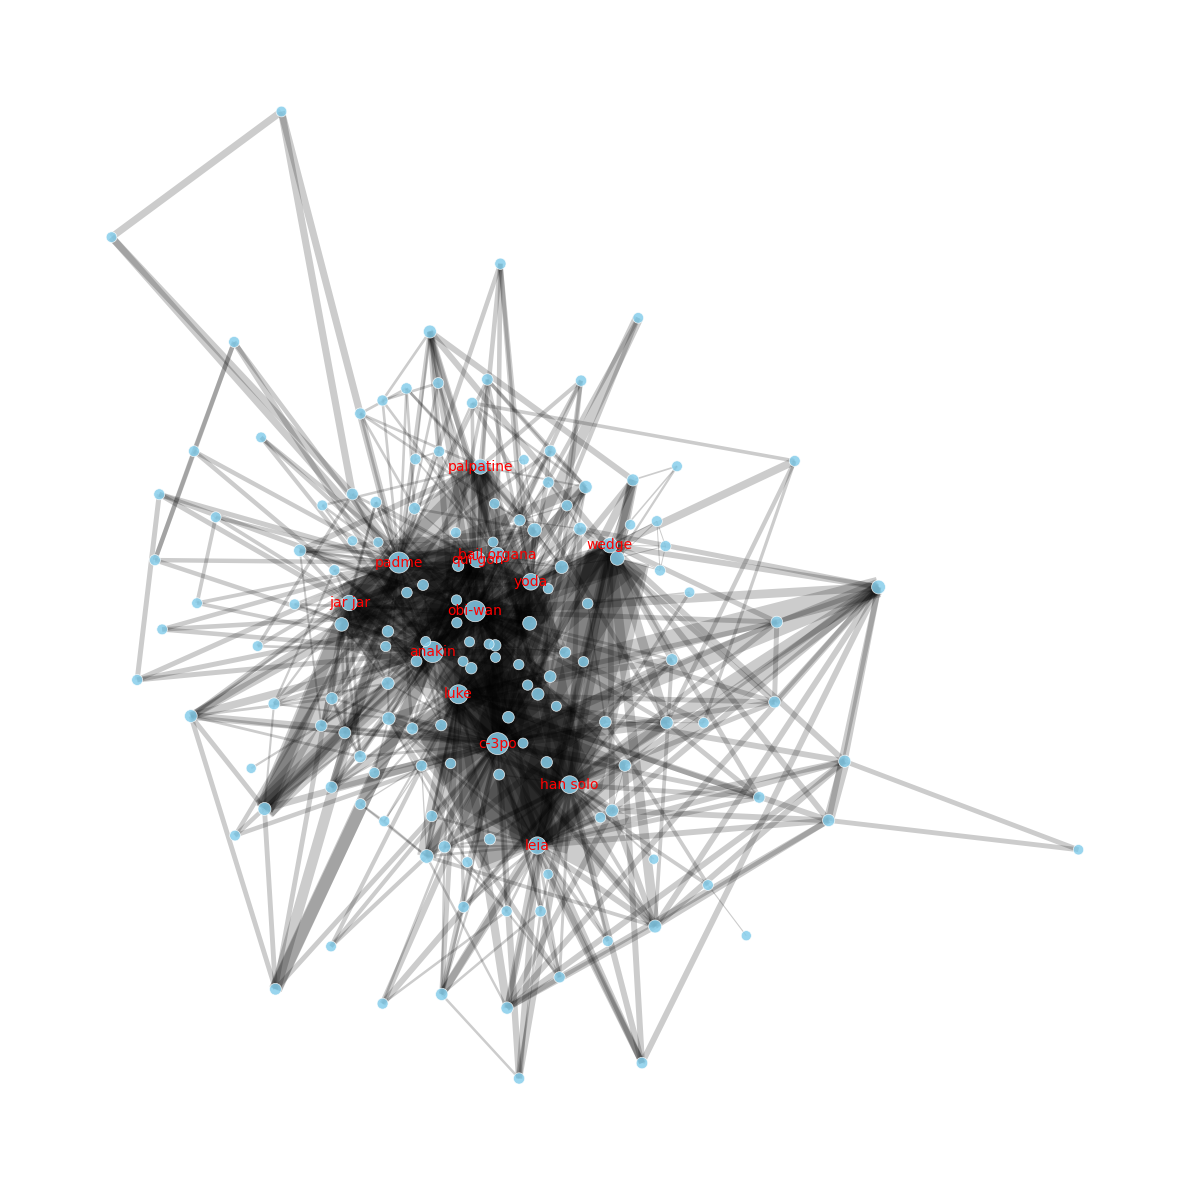

In [14]:
edge_weights = defaultdict(int)

for where,grp in df_merged.groupby('where'):
    w = len(grp)
    chars = grp['matched_name'].dropna().unique()
    for a,b in combinations(sorted(chars),2):
        edge_weights[(a,b)] += w

G = nx.Graph()
G.add_weighted_edges_from((a,b,w) for (a,b),w in edge_weights.items())

visualize(G,label_threshold=20)

# Network Analysis

### Functions/Imports

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
import community as community_louvain
import random
import json, pickle, os

def visualize_communities(G, communities, label_threshold=5, save_path=None, save_format="gml"):
    pos = nx.kamada_kawai_layout(G)
    sorted_comms = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    comm_ids = [cid for cid, _ in sorted_comms]
    cmap = get_cmap('tab20')
    node_index = {n: i for i, (_, members) in enumerate(sorted_comms) for n in members}
    node_colors = [cmap(node_index[n] / len(comm_ids)) for n in G]
    deg = dict(G.degree())
    node_sizes = [50 + 200 * (deg[n] / max(deg.values())) for n in G]
    edge_widths = [0.1 * G[u][v].get('weight', 1) for u, v in G.edges]

    fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=node_sizes,
                           alpha=0.85,
                           linewidths=0.5,
                           edgecolors='white')
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.2)
    labels = {n: n for n, d in deg.items() if d >= label_threshold}
    nx.draw_networkx_labels(G, pos,
                            labels,
                            font_size=10,
                            font_color='red')

    handles = [
        Patch(color=cmap(idx / len(comm_ids)), label=f'Community {cid}')
        for idx, cid in enumerate(comm_ids)
    ]
    ax.legend(handles=handles, title='Community', bbox_to_anchor=(1, 1))
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    if save_path:
        os.makedirs(save_path, exist_ok=True)

        graph_out = os.path.join(save_path, f"graph.{save_format}")
        comm_out_json = os.path.join(save_path, "communities.json")
        comm_out_pkl = os.path.join(save_path, "communities.pkl")

        if save_format == "gml":
            nx.write_gml(G, graph_out)
        elif save_format == "graphml":
            nx.write_graphml(G, graph_out)
        elif save_format == "pkl":
            with open(graph_out, "wb") as f:
                pickle.dump(G, f)
        else:
            raise ValueError(f"Unsupported format: {save_format}")

        # Save communities in both formats
        with open(comm_out_json, "w") as f:
            json.dump(communities, f, indent=2)

        with open(comm_out_pkl, "wb") as f:
            pickle.dump(communities, f)

        print(f"Graph saved to {graph_out}")
        print(f"Communities saved to {comm_out_json} and {comm_out_pkl}")

### 1. Basic Metrics

In [16]:
print("Number of nodes in Network: ", len(G.nodes()))
print("Number of edges in Network: ", len(G.edges()))

Number of nodes in Network:  152
Number of edges in Network:  623


**Degree:** Characters with most connections

In [17]:
degree = dict(nx.degree(G))

print("Top 5 by degree:")
print(sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 by degree:
[('c-3po', 64), ('anakin', 58), ('obi-wan', 58), ('padme', 58), ('luke', 44)]


*Interpretation*: 

These are the characters which are included in the most scenes, i.e. main characters (at least determined by screen time)

**Centrality :** Which characters are bridges between groups

In [18]:
centrality = nx.betweenness_centrality(G)

print("Top 5 by betweenness centrality:")
print(sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 by betweenness centrality:
[('c-3po', 0.2420388328124488), ('obi-wan', 0.20342861574329396), ('anakin', 0.15009084924782629), ('padme', 0.14960532363981272), ('luke', 0.11004069289297476)]


*Interpretation*: 

C-3PO is the most common characters bridging gaps between otherwise unconnected nodes, i.e. he is in the "middle". The other characters represent this as well, although not as big scale.

**Closeness :** Who has access to others quickly (in terms of dialogue chains)

In [19]:
closeness = nx.closeness_centrality(G)

print("Top 5 by closeness:")
print(sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 by closeness:
[('c-3po', 0.6141886706648096), ('obi-wan', 0.5962748344370862), ('anakin', 0.5793763573477759), ('padme', 0.5462059552095445), ('luke', 0.5359773792692909)]


*Interpretation*:

This displays the connectedness/closeness of characters. It makes sense that C-3PO is also close to many, as he is also connecting many in Centrality.

Moreover, characters like Obi-Wan and Anakin rank highly, reflecting their roles as main parts of the story that make connections across different groups. High closeness indicates that these characters can rapidly distribute information or influence through our network, making them key characters of the plot.  


### 2. Community Detection

We used Louvain Method to detect communities of the network

Showing all (7) Communities:


C:\Users\lucas\AppData\Local\Temp\ipykernel_6964\1652875224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


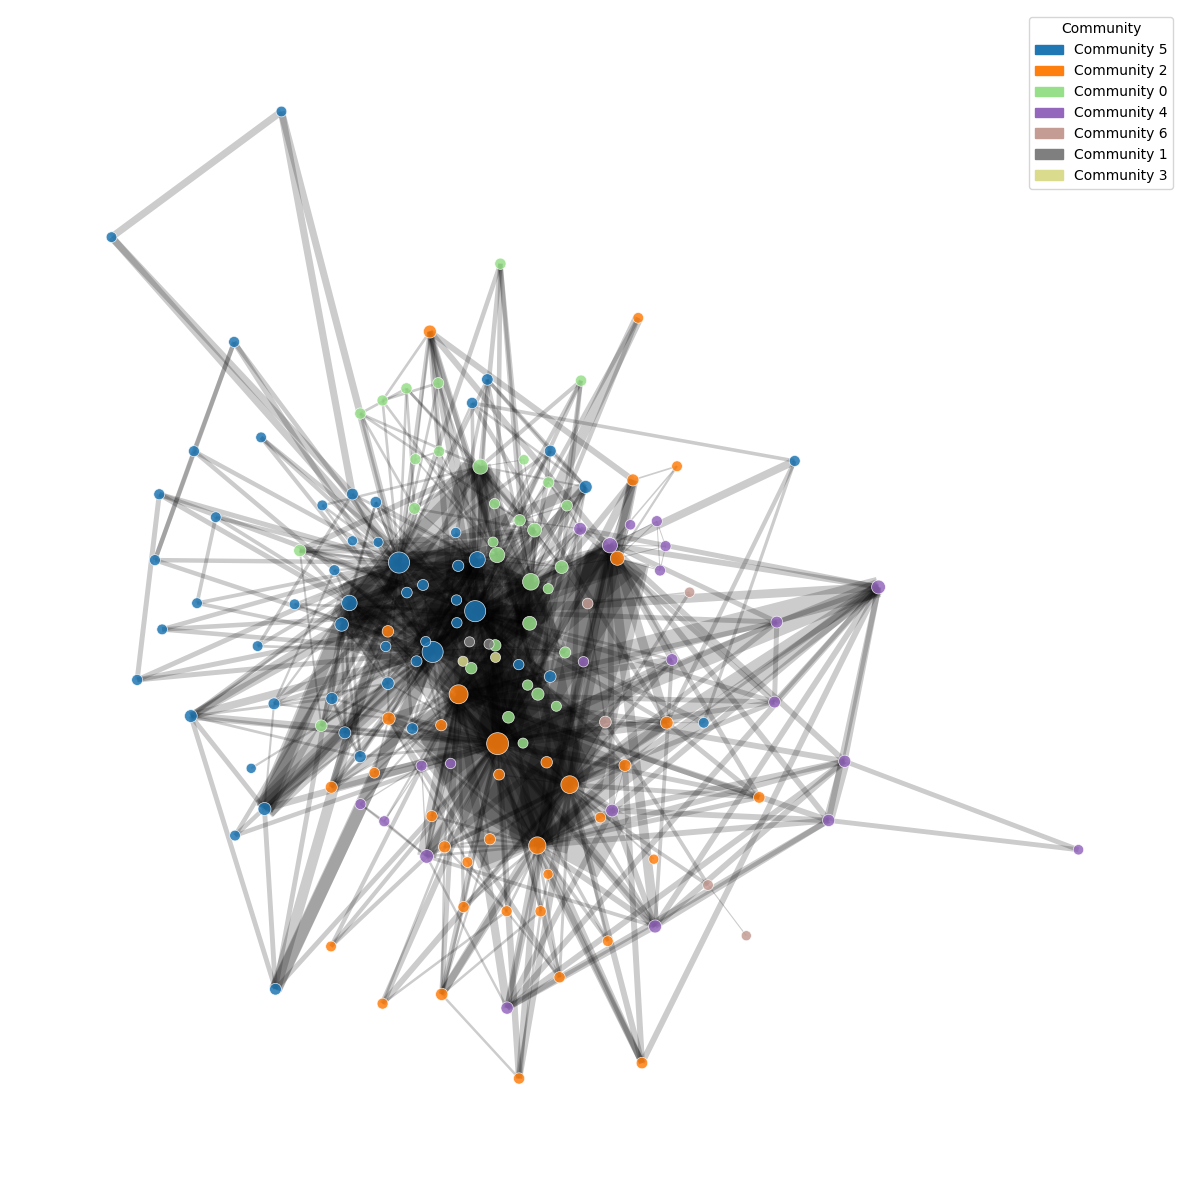

In [20]:
random.seed(33)
np.random.seed(33)

# create the communities
raw_partition = community_louvain.best_partition(
    G,
    resolution=1,
    randomize=False
)

# for reproducibility
unique_raw = sorted(set(raw_partition.values()))
reindex    = {old: new for new, old in enumerate(unique_raw)}
partition  = {
    node: reindex[raw_partition[node]]
    for node in sorted(G.nodes())
}

nx.set_node_attributes(G, partition, "community")
communities = defaultdict(list)
for node in sorted(G.nodes()):
    communities[partition[node]].append(node)

df_merged['community'] = df_merged['matched_name'].map(partition)

num_communities = len(communities)
print(f"Showing all ({num_communities}) Communities:")

visualize_communities(G, communities, label_threshold=100)

We analyse the communities to find most shared attributes as well as top characters of each community. The goal is to understand the community.

In [21]:
# creates df with only unique characters and all features, to calculate similarness of attributes for each community
df_unique   = (
    df_merged
    .drop_duplicates(subset='from')
    .drop(columns=['text','text_processed','movie_num','matched_name','where','name','pronouns'])
    .reset_index(drop=True)
    )

def top_characters_by_comm(df, top_n=3):
    result = {}
    for cid, grp in df.groupby('community'):
        counts = grp['from'].value_counts().head(top_n)
        result[cid] = list(counts.items())
    return result

# precompute global frequencies including NaNs
global_freq = {
    col: df_unique[col].value_counts(normalize=True, dropna=False)
    for col in df_unique.columns.drop('community')
}

community_similarity = {}

for cid, group in df_unique.groupby('community'):
    size = len(group)
    col_stats = []

    for col in group.columns.drop('community'):
        group_freq = group[col].value_counts(normalize=True, dropna=False)
        if group_freq.empty:
            continue

        top_val = group_freq.index[0]
        if pd.isna(top_val):
            continue

        p_comm = group_freq[top_val]
        p_glob = global_freq[col].get(top_val, 0)
        diff_pct = (p_comm - p_glob) * 100
        if diff_pct <= 0:
            continue

        col_stats.append({
            'column': col,
            'value': top_val,
            'comm_pct': p_comm * 100,
            'global_pct': p_glob * 100,
            'diff_pct': diff_pct
        })

    top3 = sorted(col_stats, key=lambda x: x['diff_pct'], reverse=True)[:3]
    community_similarity[cid] = top3

    print(f"Community {cid}, size {size}:")
    if top3:
        for stat in top3:
            print(
                f"  '{stat['column']}' = '{stat['value']}': "
                f"community {stat['comm_pct']:.1f}%, "
                f"global {stat['global_pct']:.1f}%, "
                f"diff {stat['diff_pct']:.1f}%"
            )
    else:
        print("  no overrepresented values")
    print(f'Top characters in community: {top_characters_by_comm(df_merged)[cid]}')
    print(' ')


Community 0.0, size 32:
  'trilogy' = '1': community 90.6%, global 50.8%, diff 39.8%
  'affiliation' = 'Galactic Republic': community 50.0%, global 11.4%, diff 38.6%
  'species' = 'Human (clone)': community 28.1%, global 6.3%, diff 21.8%
Top characters in community: [('yoda', 180), ('palpatine', 156), ('mace windu', 84)]
 
Community 1.0, size 2:
  'from' = 'aayla': community 50.0%, global 0.4%, diff 49.6%
  'death' = '19 BBY, Felucia': community 50.0%, global 0.4%, diff 49.6%
  'height' = '1.7 meters (5 ft, 7 in)': community 50.0%, global 0.4%, diff 49.6%
Top characters in community: [('aayla', 2), ('bly', 1)]
 
Community 2.0, size 36:
  'trilogy' = '2': community 80.6%, global 43.3%, diff 37.2%
  'gender' = 'Male': community 58.3%, global 34.3%, diff 24.1%
  'species' = 'Human': community 41.7%, global 25.2%, diff 16.5%
Top characters in community: [('luke', 493), ('han solo', 463), ('c-3po', 367)]
 
Community 3.0, size 2:
  'affiliation' = 'Trade Federation': community 100.0%, global

*Interpretation*: 

Below is our intepretation of what each community is based on, from our analysis above on matching attributes for each community. 

Community 0: Primarily characters from the first trilogy (episode 1-3), primarily from the Galactic Republic. The rest are most likely indirectly connected to character from this affiliation, placing them in this community.


Community 1: Very small community of 2 and nothing is mathcing between them from the attributes view. 


Community 2: Characters from second triology (episode 4-6), containing mostly male human characters. Again the rest are most likely  highly connected to the male humans from trilogy 2.


Community 3: Containing 2 characters only connected by their affilation, The Trade Federation.


Community 4: This community is close to community 2 in their most shared attributes being trilogy 2, human males. 


Community 5: Characters from triology 1, mostly male humans. The members that are not male or human are most likely highly connected to males and humans.


Community 6: Small group of humans from the second trilogy, 3/5 being affiliated with the Galactic republic.


From out interpretation of these communities, we observe how community 2 and community 4 seems to be the same. We will therefore use word clouds for all communities, but especially for those who seem similar at first, to find hidden relationships and distinguish between them.

### 3. Wordclouds of Communities

In [22]:
import re
import math
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import chi2
from PIL import Image
from wordcloud import WordCloud, get_single_color_func
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords

# set up stemmer + stopwords
ps = PorterStemmer()
STOPWORDS = set(stopwords.words('english'))

# clean and stem all words
def preprocess_and_stem(texts):
    out = []
    for doc in texts:
        doc = doc.lower()
        for w in word_tokenize(doc):
            w = re.sub(r'[^a-z]', '', w)
            if len(w) < 2 or w in STOPWORDS:
                continue
            out.append(ps.stem(w))
    return out

# builds bigrams, makes 2x2 tables, runs chi2 test
def find_collocations(tokens, min_count, pval_thresh):
    bigrams = [(tokens[i], tokens[i + 1]) for i in range(len(tokens) - 1)]
    bc = Counter(bigrams)
    c1 = Counter(w1 for w1, _ in bigrams)
    c2 = Counter(w2 for _, w2 in bigrams)
    total = len(bigrams)
    coll = []
    for bg, cnt in bc.items():
        if cnt < min_count:
            continue
        # make contingency table
        n11 = cnt
        n10 = c1[bg[0]] - n11
        n01 = c2[bg[1]] - n11
        n00 = total - (n11 + n10 + n01)
        # expected counts
        R1, R2 = n11 + n10, n01 + n00
        C1, C2 = n11 + n01, n10 + n00
        E11 = R1 * C1 / total
        E12 = R1 * C2 / total
        E21 = R2 * C1 / total
        E22 = R2 * C2 / total
        # chi-squared score
        chi2_val = 0
        for O, E in [(n11, E11), (n10, E12), (n01, E21), (n00, E22)]:
            if E > 0:
                chi2_val += (O - E) ** 2 / E
        # check p-value
        if chi2.sf(chi2_val, 1) < pval_thresh:
            coll.append(bg)
    return coll

# replaces bigram pairs with single tokens
def collapse_tokens(tokens, collocations):
    mwe = MWETokenizer(collocations, separator='_')
    return mwe.tokenize(tokens)

# runs all steps per community: clean → bigrams → collapse
def generate_collapsed_tokens_by_comm(df, num_comms, min_count, pval_thresh):
    result = {}
    for cid in range(num_comms + 1):
        texts = df.loc[df.community == cid, 'text_processed'].dropna().tolist()
        if not texts:
            continue
        tokens = preprocess_and_stem(texts)
        if not tokens:
            continue
        coll = find_collocations(tokens, min_count, pval_thresh)
        collapsed = collapse_tokens(tokens, coll) if coll else tokens
        result[cid] = collapsed
    return result

# makes IDF score ie how rare each word is across communities
def compute_idf(collapsed_by_comm):
    N = len(collapsed_by_comm)
    dfreq = Counter()
    for toks in collapsed_by_comm.values():
        dfreq.update(set(toks))
    return {t: math.log(N / dfreq[t]) for t in dfreq}

# multiplies word frequency × IDF
def compute_tfidf(freqs, idf):
    return {t: freqs[t] * idf.get(t, 0) for t in freqs}

# loads an image to use as wordcloud shape
def load_mask(mask_path):
    try:
        return np.array(Image.open(mask_path))
    except:
        print('MASK NOT WORKING')

# builds a wordcloud obj
def make_wordcloud(freqs, mask=None, color_theme='starwars'):
    wc = WordCloud(width=800, height=400, background_color='white', mask=mask)
    wc.generate_from_frequencies(freqs)
    # apply simple yellow theme by default
    if color_theme == 'starwars':
        wc.recolor(color_func=get_single_color_func("#f5c518"))
    return wc

# shows the wordcloud
def plot_wordcloud(arr, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(arr, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# pipeline
def create_wordcloud(
    comm_id,
    collapsed_by_comm,
    idf,
    mask_path=None,
    background_path=None,
    color_theme='starwars',
    min_characters=0,
):
    toks = collapsed_by_comm.get(comm_id)
    if not toks or len(toks) < min_characters:
        print(f"Skipping community {comm_id} (too few tokens)")
        return None

    freqs = Counter(toks)
    tfidf = compute_tfidf(freqs, idf)
    mask = load_mask(mask_path) if mask_path else None

    # build cloud (already recolored if theme is set)
    wc = make_wordcloud(tfidf, mask, color_theme=color_theme)

    # convert to RGBA so we can paste over background
    cloud_arr = wc.to_array()
    if background_path:
        bg_img = Image.open(background_path).convert('RGB')
        bg_img = bg_img.resize((cloud_arr.shape[1], cloud_arr.shape[0]))
        bg_arr = np.array(bg_img)

        # swap in cloud pixels where they are not white
        white_mask = (
            (cloud_arr[:, :, 0] == 255)
            & (cloud_arr[:, :, 1] == 255)
            & (cloud_arr[:, :, 2] == 255)
        )
        composite = bg_arr.copy()
        composite[~white_mask] = cloud_arr[~white_mask]
        plot_wordcloud(composite, f"Community {comm_id}")
        return composite
    else:
        plot_wordcloud(cloud_arr, f"Community {comm_id}")
        return cloud_arr

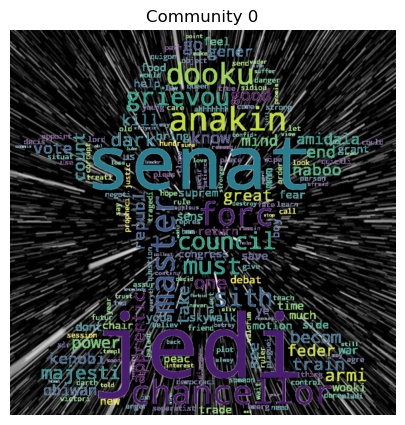

Skipping community 1 (too few tokens)


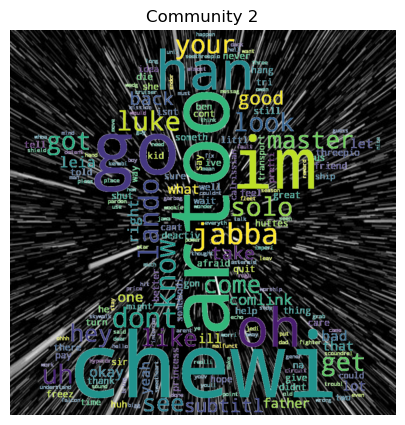

Skipping community 3 (too few tokens)


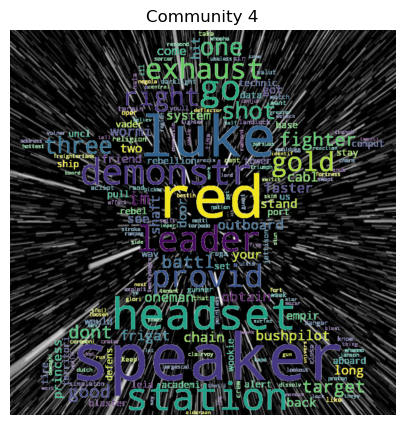

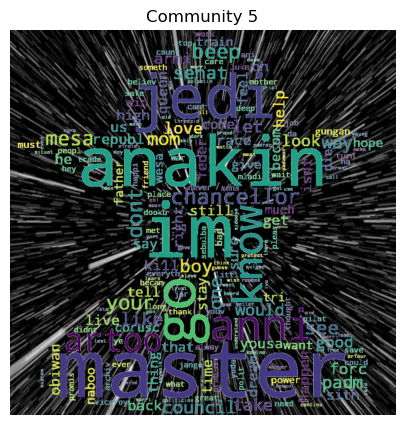

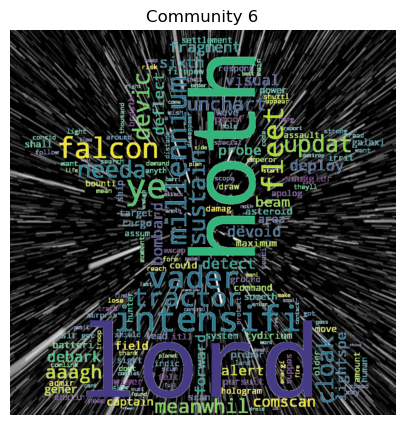

In [23]:
mask = '../wordcloud_masks/yoda.png'
background = '../assets/stars.jpg'
color_theme = ...

collapsed = generate_collapsed_tokens_by_comm(df_merged, num_communities, 50, 0.001)
idf_vals  = compute_idf(collapsed)

for cid in sorted(collapsed):
    create_wordcloud(cid, collapsed, idf_vals, mask, background, color_theme, min_characters=15)

*Interpretation*:

Community 0:

words like 'jedi', 'chancellor', 'republ' are used, indicating they are the "good guys", also backed up by the fact they are mostly from Galactic Republic. The words are more based on the first trilogy, as 'anakin', 'dooku', 'grievious' are all names of characters that only appear in the first trilogy. This community shows the Republic, the characters of it and the clone wars.

Community 2:

we see a large amount of characters from the second trilogy, i.e. 'artoo', 'jabba', 'chewy', 'han'. furthermore we see the connection between han solo and chewbacca, as han solo is the one calling him 'chewy' throughout the movies. It most likely is a connection of scenes following Han Solo and the crew (Chewy and Leia) that he travels with.

Community 4:

The wordcloud gives insight to why it is seperated from community 2. Since the communities are based on scenes, we can clearly see that community 4 describes space and space battle scenes including Luke Skywalker. Words like "frigat", "fighter", "station", "battl", "headset", "speaker", "shot", "bushpilot", "fleet" and "tractor" show a connection to space and space warfare. It may not seem  like it if you dont know Star Wars, but it definitely is words that put together represent space scenes. A lot of the smaller words also seem like they describe the first part of movie 4 where the Frigat is invaded by the empire. Other scenes could also be made out more including Luke Skywalker. 

Community 5:

This community heavily represents Anakin and his time in the first trilogy. 'Anakin', is of course here. Also words like 'anni' which is Padme's nickname for anakin, 'master' from anakin to Obi Wan. 'Jedi', 'master', 'beep', 'love', and 'chancellor' also appear showing the complexeity of Anakins situation regarding the Republic and his love for Padme. It is a great represenation of his thoughts, emotions and how he ends up in the finale of the third film joining the dark side.

Community 6:

Community 6 does not seem to show anything clearly, 'Hoth' is an iceplanet from the beginning of movie 5. 'millenium' refrences the millenium falcon Han Solo flies, 'lord' and 'vader' show some connection to the empire. 'fleet', 'cloak'  and 'tractor' is all connection to space terms. Looking further down it seems to overall represent some space and battle relation. Nothing else can be concluded, but unlike community 4, Luke Skywalker is not a main part here.

C:\Users\lucas\AppData\Local\Temp\ipykernel_6964\1652875224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


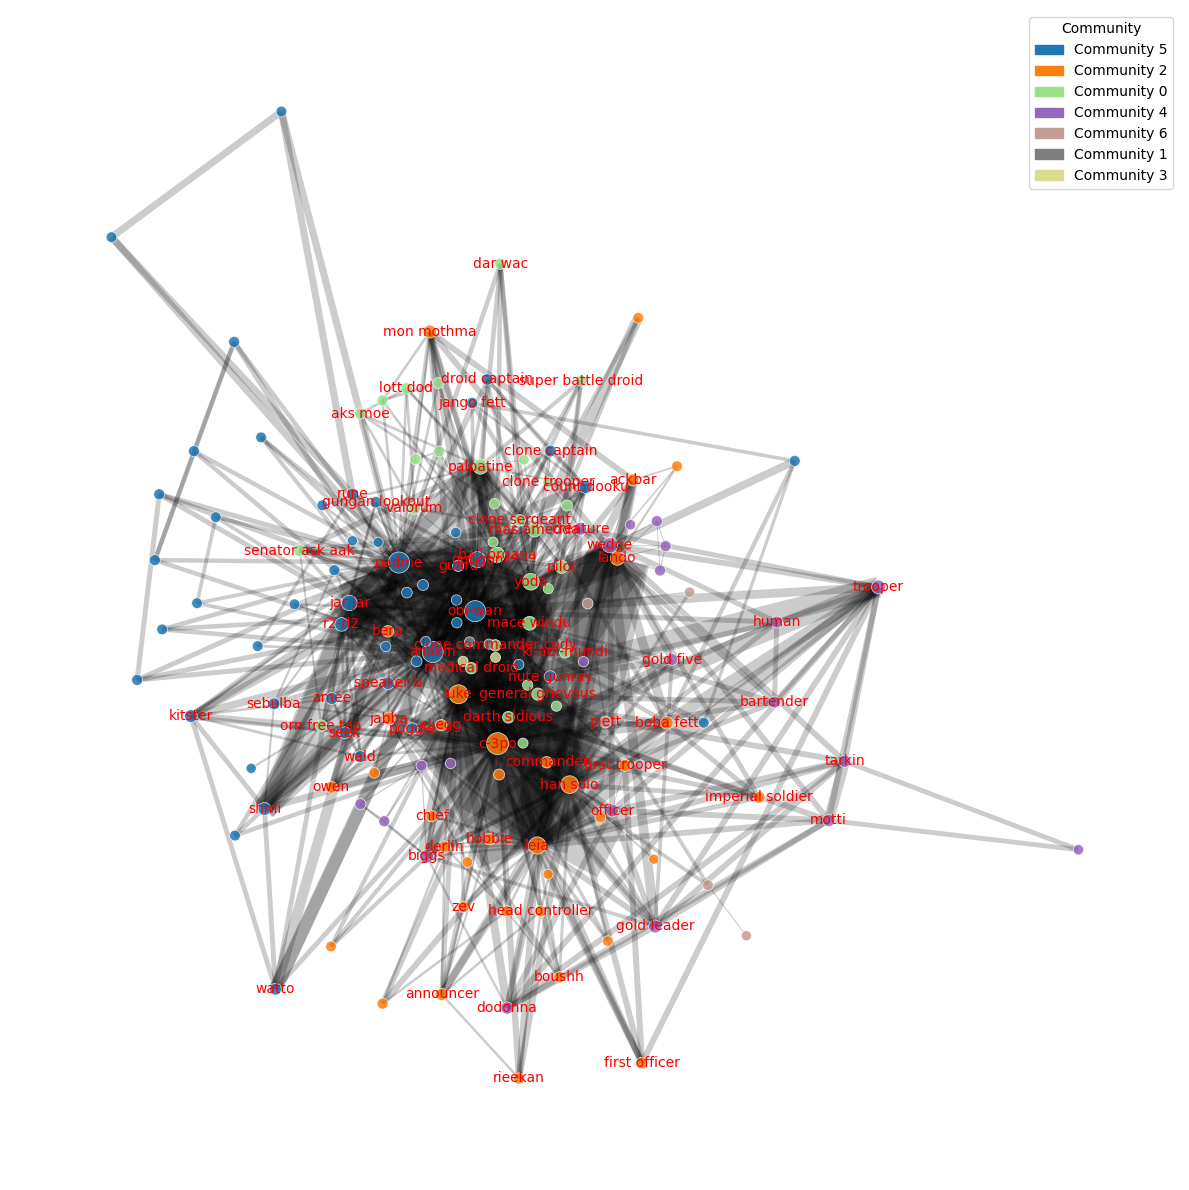

In [25]:
visualize_communities(G,communities,label_threshold=5)